1️⃣ 전체 플로우

1. 텍스트 추출 (OCR)
- **PaddleOCR** 사용 → 설계도에서 모든 텍스트 + 좌표 추출

2. 도형/선 탐지 (VFM)
- Hough Transform + OpenCV :: 구림 -> dectection_v1
- YOLOv8 이런 모델로 테스트 :: 추가학습이 필요함
- SAM 테스트 ::: mask만 제공 → 클래스별 구분, 점선/실선 식별은 후처리 필요(정보)

3. 텍스트-도형 매핑
- OCR 좌표와 도형 좌표 비교 → 도형 안에 포함되는 텍스트 연결
- 텍스트 중심점이 도형 bbox 안에 들어가면 매핑



Loading Zigeng/SlimSAM-uniform-77 model...


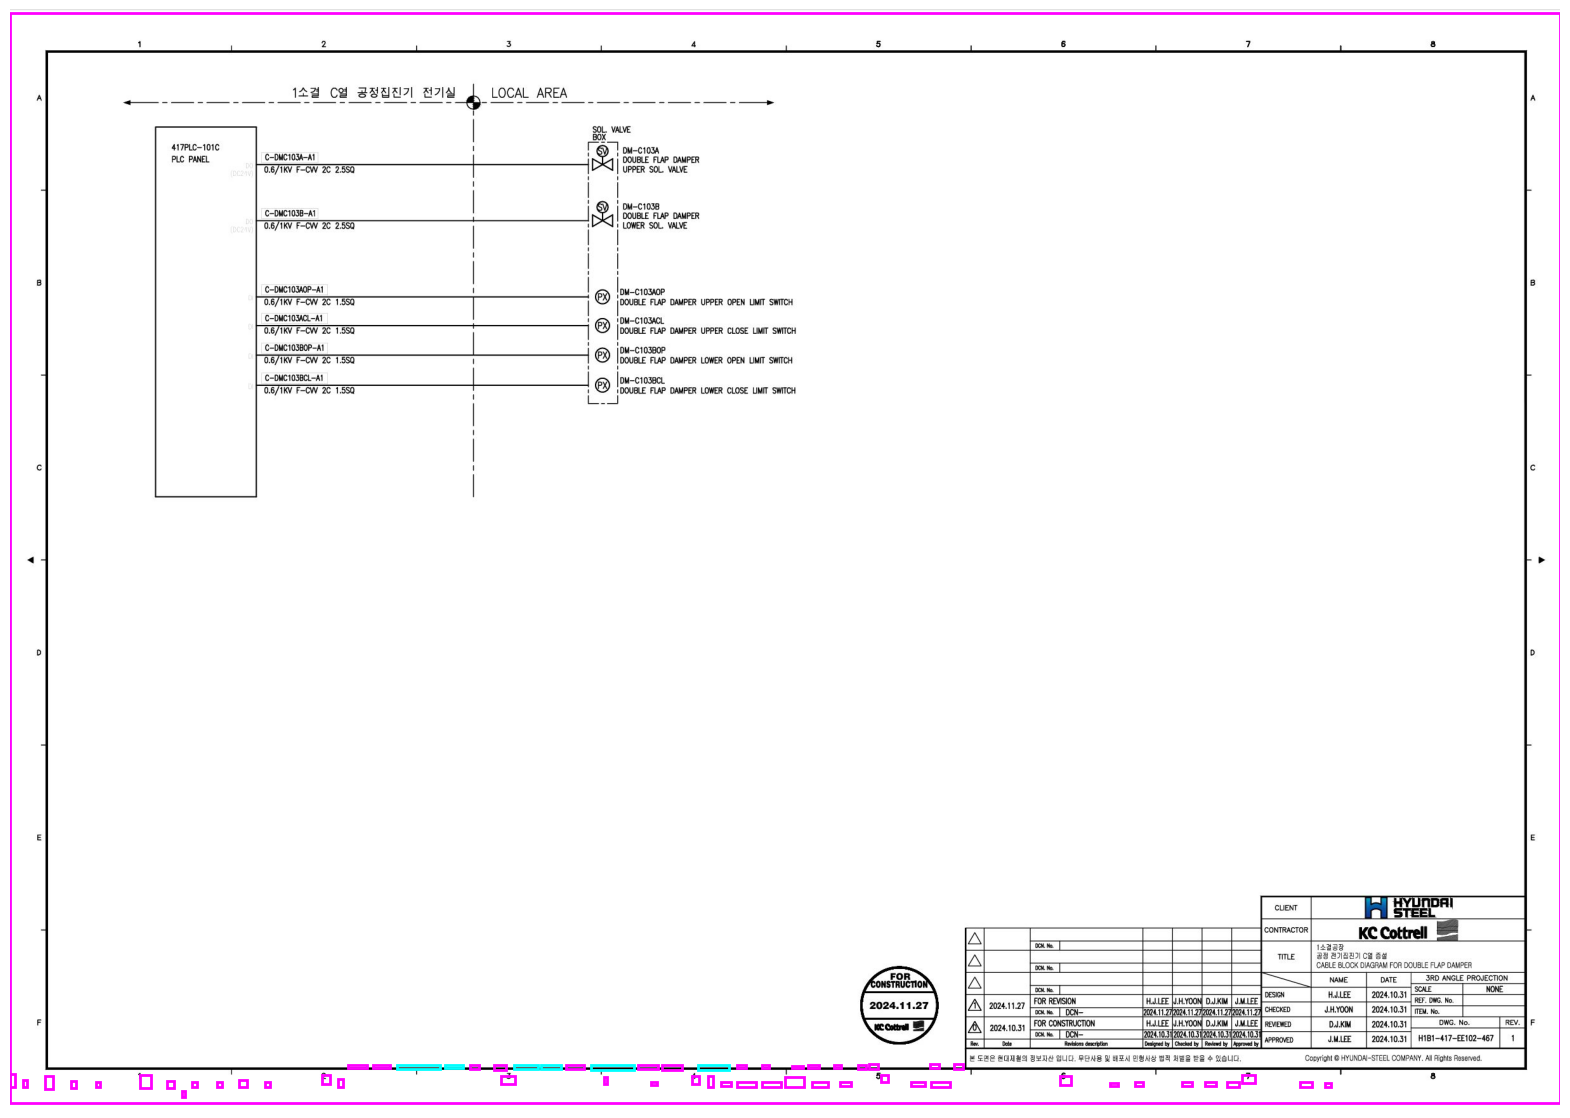

In [7]:
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import SamModel, SamProcessor
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
# 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.patches as patches

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

# -------------------------------
# 0. 이미지 로드
# -------------------------------
image_path = "./data/test05.JPG"
image_cv = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# -------------------------------
# 2. VLM
# -------------------------------
### 테스트할 이미지 부르기
image = Image.open(image_path).convert("RGB")

### 모델 부르기
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32

model_id = "Zigeng/SlimSAM-uniform-77"
print(f"Loading {model_id} model...")
model = SamModel.from_pretrained(
    model_id,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = SamProcessor.from_pretrained(model_id)

### SAM 입력 생성
W, H = image_pil.size
box = torch.tensor([[[0, 0, W, H]]], dtype=torch.float).to(device)  # 전체 이미지
inputs = processor(image_pil, boxes=box, return_tensors="pt").to(device)

# -------------------------------
# 3. SAM Forward + Mask 후처리
# -------------------------------
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)
# -------------------------------
# 4. Mask 후처리: 블록/선 구분
# -------------------------------
processed_objects = []

for mask in masks:
    mask_np = mask.cpu().numpy()       # [1,3,H,W]
    mask_np = np.squeeze(mask_np)      # [3,H,W]
    for i in range(mask_np.shape[0]):  # 3 채널 반복
        single_mask = mask_np[i]       # [H,W]
        mask_binary = (single_mask > 0).astype(np.uint8) * 255

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        mask_clean = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)
        mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h < 50:
                continue
            aspect_ratio = w / h
            obj_type = "line" if aspect_ratio > 5 or aspect_ratio < 0.2 else "block"
            processed_objects.append({
                "bbox": (x, y, w, h),
                "type": obj_type
            })

# -------------------------------
# 5. 시각화
# -------------------------------
plt.figure(figsize=(20,20))
plt.axis('off')
ax = plt.gca()
ax.imshow(image_rgb)

for obj in processed_objects:
    x, y, w, h = obj["bbox"]
    rect_color = 'cyan' if obj["type"]=="line" else 'magenta'
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=rect_color, facecolor='none'))

plt.show()